# Poutyne's Tips and Tricks

Poutyne offers a variety of tools for fine-tuning the information generated during the training, such as colouring the training update message, a progress bar, multi-GPUs, user callbacks interface and a user naming interface for the metrics' names. 

Let's install the latest version of Poutyne and colorama (if they are not already), and import all the needed packages.

In [1]:
%pip install --upgrade poutyne
%pip install --upgrade colorama
%matplotlib inline
import os
import math
import shutil

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Callback, ModelBundle, SKLearnMetrics, plot_history

## Hyperparameters, Dataset and Network

In this section, we setup the hyperparameters, dataset and network we will use throughout these tips and tricks. 

### Training Constants

Now, let's set our training constants. We first have the CUDA device used for training if one is present. Second, we set the `train_split` to 0.8 (80%) to use 80% of the dataset for training and 20% for testing the trained model. Third, we set the number of classes (i.e. one for each digit). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).

In [2]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

train_split_percent = 0.8

num_classes = 10

batch_size = 32
learning_rate = 0.1
num_epochs = 5

In Poutyne, as we will see in the following sections, you can define your own loss functions and optimizers. However, we can also pass magic strings to use PyTorch's standard optimizers and loss functions. Furthermore, for the optimizer, we can also use a dictionary to set other parameters as the learning rate, for instance, if we don't want the default learning rate.

Here, we initialize the dictionary for our optimizer as well as the string for our loss function. We thus use SGD with the specified learning rate and the cross-entropy loss.

In [3]:
optimizer = dict(optim='sgd', lr=learning_rate)  # Could be 'sgd' if we didn't need to change the learning rate.
loss_function = 'cross_entropy'

### Loading the Dataset

The following code helps load the MNIST dataset and creates the PyTorch DataLoaders that split our datasets into batches. Then, the train DataLoader shuffles the examples of the training dataset to draw the examples without replacement.

In [4]:
full_train_dataset = MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./datasets', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
train_length = int(math.floor(train_split_percent * num_data))
valid_length = num_data - train_length

train_dataset, valid_dataset = random_split(
    full_train_dataset,
    [train_length, valid_length],
    generator=torch.Generator().manual_seed(42),
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [5]:
len(train_dataset), len(valid_dataset)

(48000, 12000)

### Initializing the Network

We create a fonction to initialize a simple convolutional neural network.

In [6]:
def create_network():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes),
    )

## Vanilla Usage

The following code trains our network in the simplest way possible with Poutyne. We use the accuracy metric so that we can see the performance during training.

In [7]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
history = model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 7.33s loss: 0.392164 acc: 87.325000 val_loss: 0.085520 val_acc: 97.475000
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.66s loss: 0.133344 acc: 95.872917 val_loss: 0.063004 val_acc: 98.050000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.63s loss: 0.101859 acc: 96.885417 val_loss: 0.053152 val_acc: 98.266667
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.67s loss: 0.086312 acc: 97.347917 val_loss: 0.051262 val_acc: 98.425000
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.90s loss: 0.076157 acc: 97.666667 val_loss: 0.045157 val_acc: 98.583333
Test steps: 313 0.81s test_loss: 0.035525 test_acc: 98.780000                                                   


## Plotting Training

The training methods in Poutyne returns a list of dictionaries containing the metrics output during training. Using Poutyne, it is then possible to plot this training history.

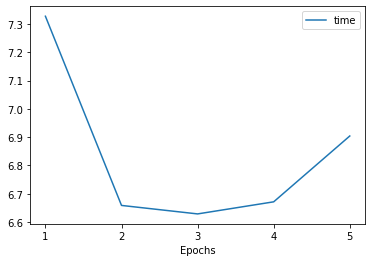

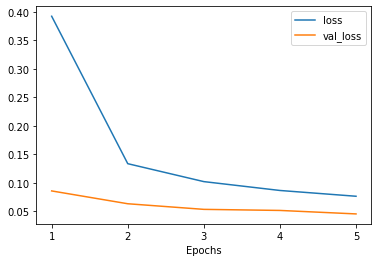

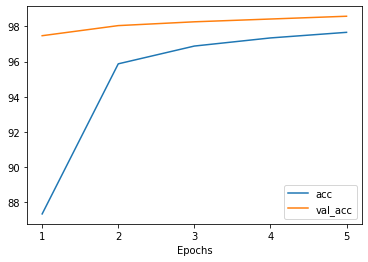

In [8]:
_ = plot_history(history)

It is also possible to restrict the metrics shown and to customize the plots by using custom labels and titles.

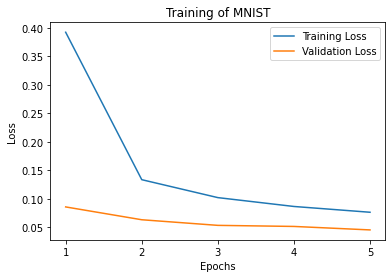

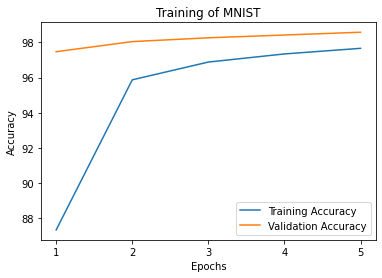

In [9]:
_ = plot_history(
    history,
    metrics=['loss', 'acc'],
    labels=['Loss', 'Accuracy'],
    titles='Training of MNIST',
)

## Initilalizing Your Optimizer and Loss Function Yourself

Instead of using magic strings for the optimizer and the loss function, it's quite easy to initialize your own and pass them to Poutyne.

In [10]:
# Instantiating our network
network = create_network()

# Instantiating our loss function and optimizer
own_optimizer = optim.SGD(network.parameters(), lr=learning_rate)
own_loss_function = nn.CrossEntropyLoss()

# Poutyne Model on GPU
model = Model(
    network,
    own_optimizer,
    own_loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.71s loss: 0.365053 acc: 88.239583 val_loss: 0.091337 val_acc: 97.400000
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.60s loss: 0.133106 acc: 96.022917 val_loss: 0.061691 val_acc: 98.150000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.54s loss: 0.101986 acc: 96.827083 val_loss: 0.057666 val_acc: 98.241667
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.78s loss: 0.086449 acc: 97.345833 val_loss: 0.058191 val_acc: 98.308333
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.71s loss: 0.078655 acc: 97.585417 val_loss: 0.041714 val_acc: 98.766667
Test steps: 313 0.85s test_loss: 0.033013 test_acc: 98.950000                                                  


## Bypassing PyTorch DataLoaders

Above, we defined DataLoaders for our datasets. However, with Poutyne, it is not strictly necessary since it provides the [`fit_dataset`](https://poutyne.org/model.html#poutyne.Model.fit_dataset) and [`evaluate_dataset`](https://poutyne.org/model.html#poutyne.Model.evaluate_dataset) methods to which you can pass the necessary parameters such as the batch size. Under the hood, Poutyne initializes the DataLoaders for you.

In [11]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_dataset(
    train_dataset,
    valid_dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    num_workers=2,
)

# Test
test_loss, test_acc = model.evaluate_dataset(
    test_dataset,
    batch_size=batch_size,
    num_workers=2,
)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.43s loss: 0.371617 acc: 87.952083 val_loss: 0.089730 val_acc: 97.333333
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.65s loss: 0.135583 acc: 95.995833 val_loss: 0.071818 val_acc: 97.825000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.70s loss: 0.101501 acc: 96.977083 val_loss: 0.061804 val_acc: 98.208333
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.67s loss: 0.084267 acc: 97.443750 val_loss: 0.049440 val_acc: 98.575000
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.72s loss: 0.074224 acc: 97.716667 val_loss: 0.053801 val_acc: 98.600000
Test steps: 313 0.85s test_loss: 0.039867 test_acc: 98.770000                                                   


## Using Callbacks

One nice feature of Poutyne is [callbacks](https://poutyne.org/callbacks.html). Callbacks allow doing actions during the training of the neural network. In the following example, we use three callbacks. The first that saves the latest weights in a file to be able to continue the optimization at the end of training if more epochs are needed. The second that saves the best weights according to the performance on the validation dataset. The last that saves the displayed logs into a TSV file.

In [12]:
# Saves everything into saves/convnet_mnist
save_path = "saves/convnet_mnist"
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [13]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.46s loss: 0.367525 acc: 88.304167 val_loss: 0.089383 val_acc: 97.275000
Epoch 1: val_acc improved from -inf to 97.27500, saving file to saves/convnet_mnist/best_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.53s loss: 0.126357 acc: 96.177083 val_loss: 0.069978 val_acc: 97.850000
Epoch 2: val_acc improved from 97.27500 to 97.85000, saving file to saves/convnet_mnist/best_epoch_2.ckpt
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.59s loss: 0.099100 acc: 97.002083 val_loss: 0.063499 val_acc: 98.008333
Epoch 3: val_acc improved from 97.85000 to 98.00833, saving file to saves/convnet_mnist/best_epoch_3.ckpt
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.57s loss: 0.086884 acc: 97.347917 val_loss: 0.046537 val_acc: 98.750000
Epoch 4: val_acc improved from 98.00833 to 98.75000, saving file to saves/convnet_mnist/best_epoch_4.ckpt
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.87s loss: 0.074684 acc: 97.683333 val_loss: 0.045957 val_acc: 

## Making Your Own Callback

While Poutyne provides a great number of [predefined callbacks](https://poutyne.org/callbacks.html), it is sometimes useful to make your own callback.

In the following example, we want to see the effect of temperature on the optimization of our neural network. To do so, we either increase or decrease the temperature during the optimization. As one can see in the result, temperature either as no effect or has a detrimental effect on the performance of the neural network. This is so because the temperature has for effect to artificially changing the learning rates. Since we have found the right learning rate, increasing or decreasing, it shows no improvement on the results.

In [14]:
class CrossEntropyLossWithTemperature(nn.Module):
    """
    This loss module is the cross-entropy loss function
    with temperature. It divides the logits by a temperature
    value before computing the cross-entropy loss.

    Args:
        initial_temperature (float): The initial value of the temperature.
    """

    def __init__(self, initial_temperature):
        super().__init__()
        self.temperature = initial_temperature
        self.celoss = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        y_pred = y_pred / self.temperature
        return self.celoss(y_pred, y_true)

In [15]:
class TemperatureCallback(Callback):
    """
    This callback multiply the loss temperature with a decay before
    each batch.

    Args:
        celoss_with_temp (CrossEntropyLossWithTemperature): the loss module.
        decay (float): The value of the temperature decay.
    """

    def __init__(self, celoss_with_temp, decay):
        super().__init__()
        self.celoss_with_temp = celoss_with_temp
        self.decay = decay

    def on_train_batch_begin(self, batch, logs):
        self.celoss_with_temp.temperature *= self.decay

So our loss function will be the cross-entropy with temperature with an initial temperature of `0.1` and a temperature decay of `1.0008`.

In [16]:
custom_loss_function = CrossEntropyLossWithTemperature(0.1)
callbacks = [TemperatureCallback(custom_loss_function, 1.0008)]

Now let's test our training loop for one epoch using the accuracy as the batch metric.

In [17]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    custom_loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.94s loss: 0.496481 acc: 84.237500 val_loss: 0.100912 val_acc: 96.958333
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.82s loss: 0.152266 acc: 95.558333 val_loss: 0.066391 val_acc: 97.975000
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.81s loss: 0.121345 acc: 96.481250 val_loss: 0.059777 val_acc: 98.200000
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.88s loss: 0.121209 acc: 96.522917 val_loss: 0.066871 val_acc: 98.133333
Epoch: 5/5 Train steps: 1500 Val steps: 375 7.09s loss: 0.132810 acc: 96.247917 val_loss: 0.078289 val_acc: 97.966667
Test steps: 313 0.86s test_loss: 0.067028 test_acc: 98.100000                                                   


## Using ModelBundle

Most of the time, when using Poutyne (or even PyTorch in general), we will find ourselves in an iterative model hyperparameters finetuning loop. For efficient model search, we will usually wish to save our best performing models, their training and testing statistics and even sometimes wish to retrain an already trained model for further tuning. All of the above can be easily implemented with the flexibility of Poutyne Callbacks, but having to define and initialize each and every Callback object we wish for our model quickly feels cumbersome.

This is why Poutyne provides a [ModelBundle class](https://poutyne.org/experiment.html#poutyne.ModelBundle), which aims specifically at enabling quick model iteration search, while not sacrificing the quality of a single experiment - statistics logging, best models saving, etc. ModelBundle is actually a simple wrapper between a PyTorch network and Poutyne's core Callback objects for logging and saving. Given a working directory where to output the various logging files and a PyTorch network, the ModelBundle class reduces the whole training loop to a single line.

The following code uses [Poutyne's ModelBundle class](https://poutyne.org/experiment.html#poutyne.ModelBundle) to train a network for 5 epochs. The code is quite simpler than the code in the Poutyne Callbacks section while doing more (only a few lines). Once trained for 5 epochs, it is then possible to resume the optimization at the 5th epoch for 5 more epochs until the 10th epoch using the same function.

In [18]:
def train_model_bundle(network, name, epochs=5):
    """
    This function creates a Poutyne ModelBundle, trains the input module
    on the train loader and then tests its performance on the test loader.
    All training and testing statistics are saved, as well as best model
    checkpoints.

    Args:
        network (torch.nn.Module): The neural network to train.
        working_directory (str): The directory where to output files to save.
        epochs (int): The number of epochs. (Default: 5)
    """
    # Everything is going to be saved in ./saves/{name}.
    save_path = os.path.join('saves', name)

    # Poutyne ModelBundle
    model_bundle = ModelBundle.from_network(
        save_path,
        network,
        optimizer=optimizer,
        task='classif',
        device=device,
    )

    # Train
    model_bundle.train(train_loader, valid_loader, epochs=epochs)

    # Test
    model_bundle.test(test_loader)

Let's first remove the output directory if it exists so that we start training from scratch.

In [19]:
shutil.rmtree('saves/convnet_mnist_model_bundle', ignore_errors=True)

Let's train for 5 epochs.

In [20]:
network = create_network()
train_model_bundle(network, 'convnet_mnist_model_bundle', epochs=5)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.39s loss: 0.378093 acc: 87.887500 fscore_macro: 0.877790 val_loss: 0.084488 val_acc: 97.583333 val_fscore_macro: 0.975736
Epoch 1: val_acc improved from -inf to 97.58333, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.37s loss: 0.126794 acc: 96.212500 fscore_macro: 0.961847 val_loss: 0.060774 val_acc: 98.166667 val_fscore_macro: 0.981594
Epoch 2: val_acc improved from 97.58333 to 98.16667, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_2.ckpt
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.31s loss: 0.097885 acc: 97.022917 fscore_macro: 0.969988 val_loss: 0.064631 val_acc: 98.191667 val_fscore_macro: 0.981835
Epoch 3: val_acc improved from 98.16667 to 98.19167, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_3.ckpt
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.31s loss: 0.082031 acc: 97.568750 fscore_macro: 0.975543 val_loss: 0.046968 val

Notice how setting `task='classif'` when instantiating `ModelBundle` adds for use our loss function, the batch metric accuracy, the epoch metric F1 and set up callbacks that use them. If you wish, you still can use your own loss function and metrics instead of passing this argument.

We have trained for 5 epochs, let's now resume training for another 5 epochs for a total of 10 epochs. Notice that we reinstantiate the network. ModelBundle will load back the weights for us and resume training.

In [21]:
network = create_network()
train_model_bundle(network, 'convnet_mnist_model_bundle', epochs=10)

Loading weights from saves/convnet_mnist_model_bundle/checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from saves/convnet_mnist_model_bundle/checkpoint.optim and starting at epoch 6.
Epoch:  6/10 Train steps: 1500 Val steps: 375 8.54s loss: 0.051976 acc: 98.350000 fscore_macro: 0.983391 val_loss: 0.047969 val_acc: 98.708333 val_fscore_macro: 0.986965
Epoch 6: val_acc improved from 98.67500 to 98.70833, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_6.ckpt
Epoch:  7/10 Train steps: 1500 Val steps: 375 8.43s loss: 0.043907 acc: 98.652083 fscore_macro: 0.986438 val_loss: 0.047314 val_acc: 98.650000 val_fscore_macro: 0.986425
Epoch:  8/10 Train steps: 1500 Val steps: 375 8.51s loss: 0.042017 acc: 98.695833 fscore_macro: 0.986879 val_loss: 0.043239 val_acc: 98.816667 val_fscore_macro: 0.988115
Epoch 8: val_acc improved from 98.70833 to 98.81667, saving file to saves/convnet_mnist_model_bundle/checkpoint_epoch_8.ckpt
Epoch:  9/10 Train steps: 1500 Val steps:

## Coloring

Also, Poutyne use by default a coloring template of the training step when the package `colorama` is installed.
One could either remove the coloring (`progress_options=dict(coloring=False)`) or set a different coloring template using the fields:
`text_color`, `ratio_color`, `metric_value_color`, `time_color` and `progress_bar_color`.
If a field is not specified, the default color will be used.
[See available colors in colorama's source code](https://github.com/tartley/colorama/blob/9946cfb/colorama/ansi.py#L49).

Here an example where we set the `text_color` to RED and the `progress_bar_color` to LIGHTGREEN_EX.

In [22]:
progress_options = dict(coloring=dict(text_color="RED", progress_bar_color="LIGHTGREEN_EX"))

In [23]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device=device,
)

# Train
model.fit_generator(
    train_loader,
    valid_loader,
    epochs=num_epochs,
    progress_options=progress_options,
)

# Test
test_loss, test_acc = model.evaluate_generator(
    test_loader,
    progress_options=progress_options,
)

Epoch: 1/5 Train steps: 1500 Val steps: 375 6.49s loss: 0.370323 acc: 88.183333 val_loss: 0.096811 val_acc: 97.033333
Epoch: 2/5 Train steps: 1500 Val steps: 375 6.81s loss: 0.128223 acc: 96.200000 val_loss: 0.066572 val_acc: 98.066667
Epoch: 3/5 Train steps: 1500 Val steps: 375 6.62s loss: 0.098609 acc: 97.047917 val_loss: 0.054764 val_acc: 98.458333
Epoch: 4/5 Train steps: 1500 Val steps: 375 6.75s loss: 0.085013 acc: 97.427083 val_loss: 0.050137 val_acc: 98.566667
Epoch: 5/5 Train steps: 1500 Val steps: 375 6.70s loss: 0.074507 acc: 97.775000 val_loss: 0.045560 val_acc: 98.625000
Test steps: 313 0.82s test_loss: 0.032162 test_acc: 98.940000                                                   


## Metrics

It's also possible to use epoch metrics such as [`F1-score`](https://poutyne.org/metrics.html#poutyne.FBeta). You could also define your own metric using the [`Metric`](https://poutyne.org/metrics.html#interface) interface.

In [24]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.34s loss: 0.357594 acc: 88.618750 fscore_macro: 0.885173 val_loss: 0.085604 val_acc: 97.491667 val_fscore_macro: 0.974808
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.27s loss: 0.125151 acc: 96.291667 fscore_macro: 0.962652 val_loss: 0.065226 val_acc: 98.041667 val_fscore_macro: 0.980284
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.02s loss: 0.098076 acc: 97.035417 fscore_macro: 0.970116 val_loss: 0.055486 val_acc: 98.391667 val_fscore_macro: 0.983862
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.20s loss: 0.086199 acc: 97.397917 fscore_macro: 0.973817 val_loss: 0.052385 val_acc: 98.441667 val_fscore_macro: 0.984307
Epoch: 5/5 Train steps: 1500 Val steps: 375 8.28s loss: 0.074596 acc: 97.714583 fscore_macro: 0.976992 val_loss: 0.044496 val_acc: 98.633333 val_fscore_macro: 0.986262
Test steps: 313 0.96s test_loss: 0.030659 test_acc: 98.930000 test_fscore_macro: 0.989244             


Furthermore, you could also use the [`SKLearnMetrics`](https://poutyne.org/metrics.html#poutyne.SKLearnMetrics) wrapper to wrap a Scikit-learn metric as an epoch metric. Below, we show how to compute the AUC ROC using the [`SKLearnMetrics`](https://poutyne.org/metrics.html#poutyne.SKLearnMetrics) class.

In [25]:
def softmax(x, axis=1):
    """
    Compute softmax function.
    """
    e_x = np.exp(x - x.max(axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def roc_auc(y_true, y_pred, **kwargs):
    """
    Since the `roc_auc_score` from Scikit-learn requires normalized probabilities,
    we use the softmax function on the predictions.
    """
    y_pred = softmax(y_pred)
    return roc_auc_score(y_true, y_pred, **kwargs)


# kwargs are keyword arguments we wish to pass to roc_auc.
roc_epoch_metric = SKLearnMetrics(roc_auc, kwargs=dict(multi_class='ovr', average='macro'))

In [26]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1', roc_epoch_metric],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1, test_roc) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.50s loss: 0.381807 acc: 87.725000 fscore_macro: 0.876033 roc_auc: 0.990784 val_loss: 0.092061 val_acc: 97.216667 val_fscore_macro: 0.971906 val_roc_auc: 0.999303
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.69s loss: 0.126951 acc: 96.183333 fscore_macro: 0.961550 roc_auc: 0.998688 val_loss: 0.062108 val_acc: 98.091667 val_fscore_macro: 0.980786 val_roc_auc: 0.999649
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.79s loss: 0.099735 acc: 96.989583 fscore_macro: 0.969644 roc_auc: 0.999133 val_loss: 0.060721 val_acc: 98.241667 val_fscore_macro: 0.982287 val_roc_auc: 0.999714
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.45s loss: 0.083001 acc: 97.554167 fscore_macro: 0.975338 roc_auc: 0.999356 val_loss: 0.049250 val_acc: 98.550000 val_fscore_macro: 0.985377 val_roc_auc: 0.999786
Epoch: 5/5 Train steps: 1500 Val steps: 375 8.58s loss: 0.074022 acc: 97.683333 fscore_macro: 0.976677 roc_auc: 0.999519 val_loss: 0.047499 val_acc: 98.633333 val_fscor

## Custom Metric Names

It's also possible to name the metric using a tuple format `(<metric name>, metric)`. That way, it's possible to use multiple times the same metric type (i.e. having micro and macro F1-score).

In [27]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=[("My accuracy name", 'accuracy')],
    epoch_metrics=[("My f1 name", 'f1')],
    device=device,
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

# Test
test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch: 1/5 Train steps: 1500 Val steps: 375 8.28s loss: 0.406818 My accuracy name: 86.564583 My f1 name: 0.865036 val_loss: 0.091769 val_My accuracy name: 97.191667 val_My f1 name: 0.971806
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.26s loss: 0.128237 My accuracy name: 96.120833 My f1 name: 0.960871 val_loss: 0.064072 val_My accuracy name: 98.141667 val_My f1 name: 0.981286
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.34s loss: 0.096778 My accuracy name: 97.062500 My f1 name: 0.970436 val_loss: 0.054216 val_My accuracy name: 98.375000 val_My f1 name: 0.983604
Epoch: 4/5 Train steps: 1500 Val steps: 375 8.50s loss: 0.079858 My accuracy name: 97.572917 My f1 name: 0.975558 val_loss: 0.049437 val_My accuracy name: 98.608333 val_My f1 name: 0.985975
Epoch: 5/5 Train steps: 1500 Val steps: 375 8.27s loss: 0.071876 My accuracy name: 97.785417 My f1 name: 0.977690 val_loss: 0.043721 val_My accuracy name: 98.675000 val_My f1 name: 0.986609
Test steps: 313 0.95s test_loss: 0.030263 test_My 

## Multi-GPUs

Finally, it's also possible to use multi-GPUs for your training either by specifying a list of devices or using the arg `"all"` to take them all.

> Obviously, you need more than one GPUs for that option.

In our case here, multi-gpus takes more time because the task is not big enough to profit from multi-gpus.

In [28]:
# Instantiating our network
network = create_network()

# Poutyne Model on GPU
model = Model(
    network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    device="all",
)

# Train
model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

Epoch: 1/5 Train steps: 1500 Val steps: 375 18.30s loss: 0.363074 acc: 88.327083 val_loss: 0.082302 val_acc: 97.591667
Epoch: 2/5 Train steps: 1500 Val steps: 375 14.45s loss: 0.130380 acc: 96.039583 val_loss: 0.067326 val_acc: 98.050000
Epoch: 3/5 Train steps: 1500 Val steps: 375 14.44s loss: 0.102080 acc: 96.910417 val_loss: 0.060734 val_acc: 98.275000
Epoch: 4/5 Train steps: 1500 Val steps: 375 14.48s loss: 0.084889 acc: 97.414583 val_loss: 0.044693 val_acc: 98.708333
Epoch: 5/5 Train steps: 1500 Val steps: 375 14.60s loss: 0.074630 acc: 97.729167 val_loss: 0.049067 val_acc: 98.508333


[{'epoch': 1,
  'time': 18.295885302009992,
  'loss': 0.3630740385986865,
  'acc': 88.32708333333333,
  'val_loss': 0.08230177901592106,
  'val_acc': 97.59166666666667},
 {'epoch': 2,
  'time': 14.453654351993464,
  'loss': 0.13038020479671347,
  'acc': 96.03958333333334,
  'val_loss': 0.06732586475741119,
  'val_acc': 98.05},
 {'epoch': 3,
  'time': 14.443042377999518,
  'loss': 0.10208004223524282,
  'acc': 96.91041666666666,
  'val_loss': 0.060733863756138214,
  'val_acc': 98.275},
 {'epoch': 4,
  'time': 14.475745540985372,
  'loss': 0.08488924899002692,
  'acc': 97.41458333333334,
  'val_loss': 0.04469311863329494,
  'val_acc': 98.70833333333333},
 {'epoch': 5,
  'time': 14.59749897295842,
  'loss': 0.07463015206251293,
  'acc': 97.72916666666667,
  'val_loss': 0.04906748805160169,
  'val_acc': 98.50833333333334}]